In [ ]:
#install Kaggle
!pip install -q kaggle

from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"syaqila","key":"9cfe244b2f6e7252fdb9b8ea9bb24f39"}'}

In [ ]:
#create a kaggle folder
! mkdir ~/.kaggle

#copy the kaggle.json to folder created
! cp kaggle.json ~/.kaggle/

#permission for the json to act
! chmod 600 ~/.kaggle/kaggle.json

#to list all datasets in kaggle
! kaggle datasets list

! kaggle datasets download -d sartajbhuvaji/brain-tumor-classification-mri

ref                                                            title                                             size  lastUpdated          downloadCount  voteCount  usabilityRating  
-------------------------------------------------------------  -----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
rahulvyasm/netflix-movies-and-tv-shows                         Netflix Movies and TV Shows                        1MB  2024-04-10 09:48:38          22714        497  1.0              
jainaru/world-happiness-report-2024-yearly-updated             World Happiness Report- 2024                      62KB  2024-05-15 19:04:34           2225         42  1.0              
keremabdullahoglu/laptop-price-dataset-april-2024              Laptop Price Dataset April 2024                  243KB  2024-05-18 11:28:48           1137         35  1.0              
emirhanai/social-media-usage-and-emotional-well-being          Social Media Usag

In [ ]:
! unzip brain-tumor-classification-mri.zip

Archive:  brain-tumor-classification-mri.zip
  inflating: Testing/glioma_tumor/image(1).jpg  
  inflating: Testing/glioma_tumor/image(10).jpg  
  inflating: Testing/glioma_tumor/image(100).jpg  
  inflating: Testing/glioma_tumor/image(11).jpg  
  inflating: Testing/glioma_tumor/image(12).jpg  
  inflating: Testing/glioma_tumor/image(13).jpg  
  inflating: Testing/glioma_tumor/image(14).jpg  
  inflating: Testing/glioma_tumor/image(15).jpg  
  inflating: Testing/glioma_tumor/image(16).jpg  
  inflating: Testing/glioma_tumor/image(17).jpg  
  inflating: Testing/glioma_tumor/image(18).jpg  
  inflating: Testing/glioma_tumor/image(19).jpg  
  inflating: Testing/glioma_tumor/image(2).jpg  
  inflating: Testing/glioma_tumor/image(20).jpg  
  inflating: Testing/glioma_tumor/image(21).jpg  
  inflating: Testing/glioma_tumor/image(22).jpg  
  inflating: Testing/glioma_tumor/image(23).jpg  
  inflating: Testing/glioma_tumor/image(24).jpg  
  inflating: Testing/glioma_tumor/image(25).jpg  
  infl

In [ ]:
import os
import pathlib
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import Precision, Recall, SensitivityAtSpecificity
import matplotlib.pyplot as plt
from tensorflow.keras.initializers import GlorotNormal
from tensorflow.keras.applications import densenet

In [ ]:
class Brain_Tumor:
    def __init__(self, epochs, batch_size, dataset_folder, optimizer, loss):
        self.epochs = epochs
        self.batch_size = batch_size
        self.dataset_folder = dataset_folder
        self.optimizer = optimizer
        self.loss = loss
        self.classes = ["meningioma", "glioma", "pituitary"]
        self.train_dataset_files = self._load_dataset_files('Training')
        self.test_dataset_files = self._load_dataset_files('Testing')
        self.collect_features_labels()  # collect features and labels upon initialization

    def _load_dataset_files(self, subset):
        dataset_files = []
        subset_folder = pathlib.Path(os.path.join(self.dataset_folder, subset))
        for label in self.classes:
            folder_path = subset_folder / label
            files = list(folder_path.glob("*.jpg"))
            dataset_files.extend([(file, label) for file in files])
        return dataset_files

    def read_image_file(self, single_file):
        img = cv2.imread(str(single_file), cv2.IMREAD_GRAYSCALE)
        return img

    def collect_features_labels(self):
        self.images = []
        self.labels = []
        dataset_files = self.train_dataset_files + self.test_dataset_files
        for single_file, label in dataset_files:
            img = self.read_image_file(single_file)
            img = img / 255.0  # Normalization
            img = np.float32(img)
            img = cv2.resize(img, (224, 224))
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
            img = img - np.mean(img)
            img = img / np.std(img)
            self.images.append(img)
            label_index = self.classes.index(label)
            self.labels.append(label_index)
        self.images = np.asarray(self.images)
        self.labels = np.asarray(self.labels)

    def DataAugmentation_Object(self):
        return tf.keras.preprocessing.image.ImageDataGenerator(
            rotation_range=0.2,
            zoom_range=0.01,
            horizontal_flip=True,
            vertical_flip=True,
            rescale=None
        )

    def augmentated_images(self):
        images_after_aug = []
        labels_after_aug = []
        augmentation_object = self.DataAugmentation_Object()
        for index, image in enumerate(self.X_train):
            for i in range(3):
                img = augmentation_object.flow(np.reshape(image, (1, 224, 224, 3))).next()
                images_after_aug.append(np.reshape(img, (224, 224, 3)))
                labels_after_aug.append(self.y_train[index])
        self.y_train = np.asarray(labels_after_aug)
        self.X_train = np.asarray(images_after_aug)

    def Model(self):
        d = densenet.DenseNet121(weights=None, include_top=False, input_shape=(224, 224, 3))
        m = tf.keras.layers.Dropout(0.8)(d.output)
        m = tf.keras.layers.GlobalAveragePooling2D(name="GlobalAveragePooling2D_")(m)
        m = tf.keras.layers.Dropout(0.8)(m)
        m = tf.keras.layers.Dense(3, kernel_initializer=GlorotNormal(),
                                  activation='softmax', kernel_regularizer=tf.keras.regularizers.L2(0.0001),
                                  bias_regularizer=tf.keras.regularizers.L2(0.0001))(m)
        m = tf.keras.models.Model(inputs=d.input, outputs=m)
        m.load_weights("chexnet-weights/brucechou1983_CheXNet_Keras_0.3.0_weights.h5", by_name=True, skip_mismatch=True)
        for layer in m.layers[:200]:
            layer.trainable = False
        for layer in m.layers[200:]:
            layer.trainable = True
        self.m = m

    def compile(self):
        self.m.compile(optimizer=self.optimizer,
                       loss=self.loss, metrics=['accuracy', Precision(), Recall(), SensitivityAtSpecificity(0.5)])

    def fit_model(self):
        self.history = self.m.fit(self.X_train, self.y_train, epochs=self.epochs, batch_size=self.batch_size,
                                  validation_data=(self.X_test, self.y_test),
                                  callbacks=[tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, mode='min',
                                                                                  patience=2),
                                             tf.keras.callbacks.EarlyStopping(patience=250, monitor='val_loss', mode='min', restore_best_weights=True)])


In [ ]:
Brain_Tumor_obj = Brain_Tumor(150,
                              64,
                              'brain_tumor_dataset',
                              tf.keras.optimizers.Adam(0.001),
                              'categorical_crossentropy')

IndexError: index 0 is out of bounds for axis 0 with size 0

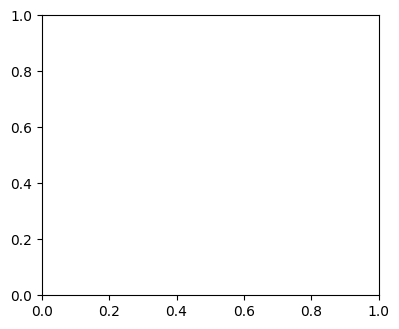

In [ ]:
Brain_Tumor_obj.collect_features_labels()

plt.figure(figsize = (20, 8))
for i in range(8):
  plt.subplot(2, 4, i+ 1)
  plt.imshow(Brain_Tumor_obj.images[i])
  plt.title(Brain_Tumor_obj.classes[Brain_Tumor_obj.labels[i] - 1])
plt.show()

In [ ]:
Brain_Tumor_obj.augmentated_images()

plt.figure(figsize = (20, 8))
for i in range(8):
  plt.subplot(2, 4, i + 1)
  plt.imshow(Brain_Tumor_obj.images[i])
  plt.title(Brain_Tumor_obj.classes[Brain_Tumor_obj.labels[i] - 1])
plt.show()

In [ ]:
Brain_Tumor_obj.to_categorical_label()

In [ ]:
Brain_Tumor_obj.Model()
Brain_Tumor_obj.compile()
Brain_Tumor_obj.fit_model()

In [ ]:
Brain_Tumor_obj.m.summary()

In [ ]:
plt.plot(Brain_Tumor_obj.history.history['loss'], label = "loss")
plt.plot(Brain_Tumor_obj.history.history['val_loss'], label = "validation loss")
plt.legend()

In [ ]:
plt.plot(Brain_Tumor_obj.history.history['accuracy'], label = "accuracy")
plt.plot(Brain_Tumor_obj.history.history['val_accuracy'], label = "validation accuracy")
plt.legend()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
Brain_Tumor_obj.m.save("drive/MyDrive/brain_tumor_model.h5")
Brain_Tumor_obj.m.save_weights("drive/MyDrive/brain_tumor_weights.h5")

In [ ]:
Brain_Tumor_obj.m.evaluate(Brain_Tumor_obj.X_test,
                           Brain_Tumor_obj.y_test, batch_size = 2)

In [ ]:
y_pred = Brain_Tumor_obj.m.predict(Brain_Tumor_obj.X_test)

In [ ]:
y_pred = np.argmax(y_pred, axis = 1)

In [ ]:
y_test = np.argmax(Brain_Tumor_obj.y_test, axis = 1)

In [ ]:
from sklearn.metrics import accuracy_score as ac
ac(y_pred, y_test)

In [ ]:
import seaborn as sns
sns.heatmap(tf.math.confusion_matrix(
    y_test,
    y_pred,
), annot=True)